In [2]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')

In [3]:
# My mac
#data = pd.read_csv("/RawDataCSV/plotsClimateData_11092017.csv")
# My Linux desktop
data = pd.read_csv("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")


/opt/conda/envs/biospytial/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
import geopandas as gpd

In [5]:
from django.contrib.gis import geos
from shapely.geometry import Point

In [6]:
data['geometry'] = data.apply(lambda z: Point(z.LON, z.LAT), axis=1)
new_data = gpd.GeoDataFrame(data)

## Let´s reproject to Alberts or something with distance

In [7]:
new_data.crs = {'init':'epsg:4326'}


### Uncomment to reproject
proj string taken from: http://spatialreference.org/

In [8]:
new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")
new_data['newLon'] = new_data.apply(lambda c : c.geometry.x, axis=1)
new_data['newLat'] = new_data.apply(lambda c : c.geometry.y, axis=1)

In [9]:
new_data['logBiomass'] = np.log(new_data.plotBiomass)
new_data['logSppN'] = np.log(new_data.SppN)

In [10]:
## Save new data in outputs
#new_data.to_csv('/outputs/fia_plots_reproject.csv')

In [11]:
## Let´s make a simple linear trend here.
import statsmodels.api as sm
import statsmodels.formula.api as smf



In [12]:
## All data
### Now with statsmodels.api

#xx = X.SppN.values.reshape(-1,1)
#xx = sm.add_constant(xx)
#model = sm.OLS(Y.values.reshape(-1,1),xx)

model = smf.ols(formula='logBiomass ~ logSppN',data=new_data)
results = model.fit()
param_model = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logBiomass   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     4757.
Date:                Tue, 28 Nov 2017   Prob (F-statistic):               0.00
Time:                        21:16:04   Log-Likelihood:                -36670.
No. Observations:               36845   AIC:                         7.334e+04
Df Residuals:                   36843   BIC:                         7.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.4882      0.009    976.347      0.000         8.471     8.505
logSppN        0.3740      0.005     68.974      0.000         0.363     0.385
==============================================================================
Omnibus:                     1627.980   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2356.149
Skew:                          -0.421   Prob(JB):                         0.00
Kurtosis:                       3.908   Cond. No.                         5.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
new_data['residuals1'] = results.resid

## Subseting the data

Three different methods for subsetting the data.
1. Using a systematic selection by index modulus
2. Using a random uniform selection by indices.
2. A geographic subselection (Clip)

### Systematic selection

In [14]:
def systSelection(n,k):
    idxs = range(0,n,k)
    systematic_sample = new_data.iloc[idxs]
    return systematic_sample
##################
n = len(new_data)
k = 10 # The k-th element to take as a sample

In [15]:
systematic_sample = systSelection(n,k)

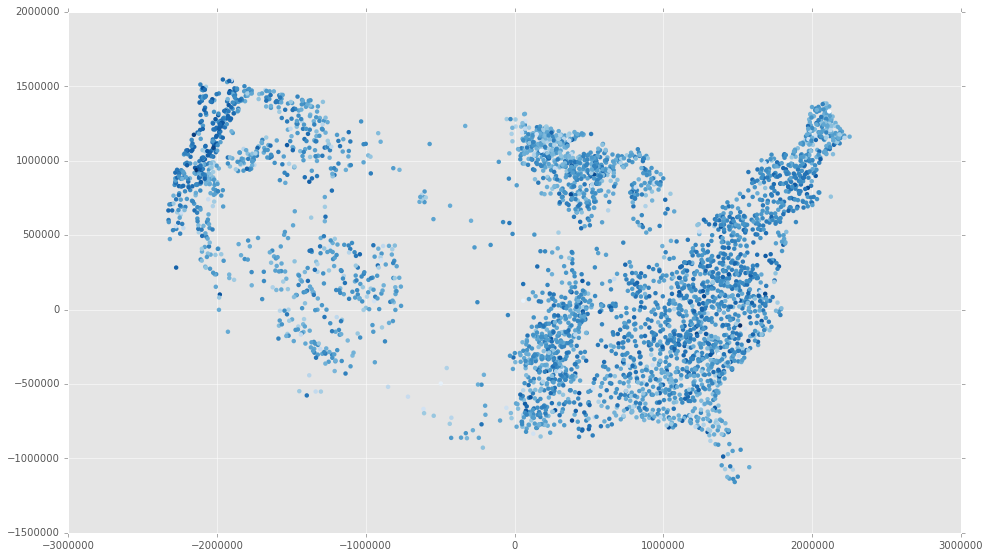

In [16]:
ax= systematic_sample.plot(column='logBiomass',figsize=(16,10),cmap=plt.cm.Blues,edgecolors='') 

### Random (Uniform) selection


In [17]:
def randomSelection(n,p):
    idxs = np.random.choice(n,p,replace=True)
    random_sample = new_data.iloc[idxs]
    return random_sample
#################
n = len(new_data)
p = 3000 # The amount of samples taken (let's do it without replacement)

In [18]:
random_sample = randomSelection(n,p)

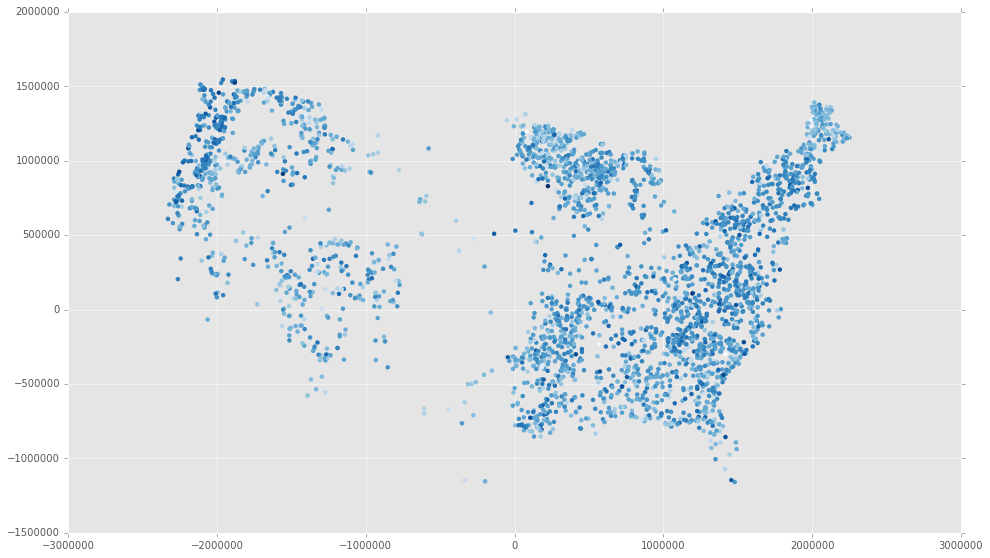

In [19]:
ax= random_sample.plot(column='logBiomass',figsize=(16,10),cmap=plt.cm.Blues,edgecolors='') 


### Geographic subselection

In [20]:
def subselectDataFrameByCoordinates(dataframe,namecolumnx,namecolumny,minx,maxx,miny,maxy):
    """
    Returns a subselection by coordinates using the dataframe/
    """
    minx = float(minx)
    maxx = float(maxx)
    miny = float(miny)
    maxy = float(maxy)
    section = dataframe[lambda x:  (x[namecolumnx] > minx) & (x[namecolumnx] < maxx) & (x[namecolumny] > miny) & (x[namecolumny] < maxy) ]
    return section

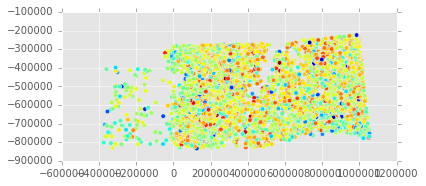

In [21]:
# COnsider the the following subregion
minx = -100
maxx = -85
miny = 30
maxy = 35

section = subselectDataFrameByCoordinates(new_data,'LON','LAT',minx,maxx,miny,maxy)

#section = new_data[lambda x:  (x.LON > minx) & (x.LON < maxx) & (x.LAT > miny) & (x.LAT < maxy) ]
section.plot(column='logBiomass')



## Model Analysis with the empirical variogram


In [22]:
from external_plugins.spystats import tools

#### Global Variogram
Calculated previously. Here I want to check if by taking some of these subsamples is possible to capture the spatial structure.

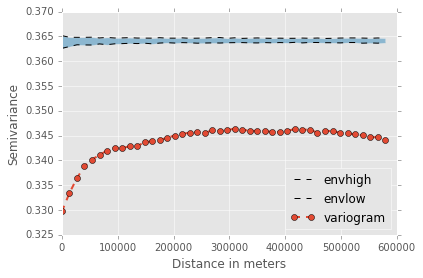

In [23]:
thrs_dist = 600000
nt = 30 # num iterations
filename = "../HEC_runs/results/low_q/data_envelope.csv"
envelope_data = pd.read_csv(filename)
gvg = tools.Variogram(new_data,'logBiomass',using_distance_threshold=thrs_dist)
gvg.envelope = envelope_data
gvg.empirical = gvg.envelope.variogram
gvg.lags = gvg.envelope.lags
vdata = gvg.envelope.dropna()
gvg.plot(refresh=False,legend=False)


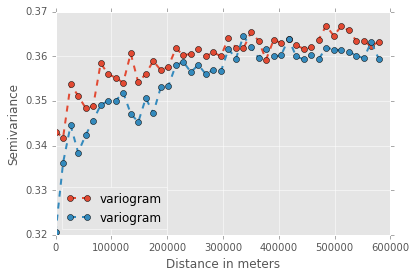

In [24]:
## For systematic sample
systematic_variogram = tools.Variogram(systematic_sample,'logBiomass',using_distance_threshold=thrs_dist)
sysemp = systematic_variogram.calculateEmpirical()
#systematic_variogram.calculateEnvelope(num_iterations=nt)
systematic_variogram.plot(with_envelope=False)
#syst = systematic_variogram.envelope[['lags','empirical']]
## For random sample
random_variogram = tools.Variogram(random_sample,'logBiomass',using_distance_threshold=thrs_dist)
random_variogram.plot(with_envelope=False)
#random_variogram.calculateEnvelope(num_iterations=nt)
#randemp = random_variogram.calculateEmpirical()
#rand = random_variogram.envelope[['lags','empirical']]
## For geographic sample
geographic_variogram = tools.Variogram(section,'logBiomass',using_distance_threshold=thrs_dist)
#geographic_variogram.calculateEnvelope(num_iterations=nt)
geoemp = geographic_variogram.calculateEmpirical()
#geog = geographic_variogram.envelope[['lags','empirical']]

In [25]:
## For systematic sample
systsamps = map(lambda k : systSelection(n,k), range(5,30))
vgs = map(lambda sample : tools.Variogram(sample,'logBiomass',using_distance_threshold=thrs_dist),systsamps)
emps = map(lambda vg : vg.calculateEmpirical(),vgs)

In [26]:
d = pd.concat([vgs[0].lags,pd.DataFrame(emps).transpose()],axis=1)


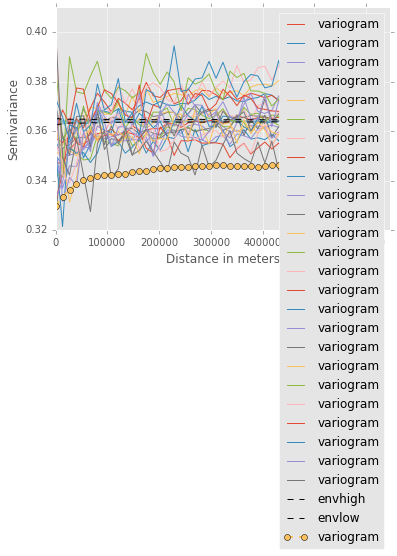

In [27]:
d.variogram.plot(x=d.lags.values,legend=False)
gvg.plot(refresh=False,legend=False)

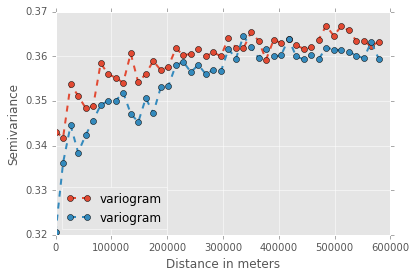

In [28]:
systematic_variogram = tools.Variogram(systematic_sample,'logBiomass',using_distance_threshold=thrs_dist)
sysemp = systematic_variogram.calculateEmpirical()
#systematic_variogram.calculateEnvelope(num_iterations=nt)
systematic_variogram.plot(with_envelope=False)
#syst = systematic_variogram.envelope[['lags','empirical']]
## For random sample
random_variogram = tools.Variogram(random_sample,'logBiomass',using_distance_threshold=thrs_dist)
random_variogram.plot(with_envelope=False)
#random_variogram.calculateEnvelope(num_iterations=nt)
#randemp = random_variogram.calculateEmpirical()
#rand = random_variogram.envelope[['lags','empirical']]
## For geographic sample
geographic_variogram = tools.Variogram(section,'logBiomass',using_distance_threshold=thrs_dist)
#geographic_variogram.calculateEnvelope(num_iterations=nt)
geoemp = geographic_variogram.calculateEmpirical()
#geog = geographic_variogram.envelope[['lags','empirical']]

## Fitting the empirical variogram to into a theoretical model

# Valid parametric empirical variogram
That, covariance matrix always postive semi-definite.
## Gaussian Model
$$\gamma (h)=(s-n)\left(1-\exp \left(-{\frac  {h^{2}}{r^{2}a}}\right)\right)+n1_{{(0,\infty )}}(h)$$

In [29]:
def gaussianVariogram(h,sill=0,range_a=0,nugget=0):
    if isinstance(h,np.ndarray):
        Ih = np.array([1.0 if hx >= 0.0 else 0.0 for hx in h])
    else:
        Ih = 1.0 if h >= 0 else 0.0
    #Ih = 1.0 if h >= 0 else 0.0    
    g_h = ((sill - nugget)*(1 - np.exp(-(h**2 / range_a**2)))) + nugget*Ih
    return g_h

## Exponential Model
$$\gamma (h)=(s-n)(1-\exp(-h/(ra)))+n1_{{(0,\infty )}}(h)$$

In [30]:
def exponentialVariogram(h,sill=0,range_a=0,nugget=0):
    if isinstance(h,np.ndarray):
        Ih = np.array([1.0 if hx >= 0.0 else 0.0 for hx in h])
    else:
        Ih = 1.0 if h >= 0 else 0.0
    g_h = (sill - nugget)*(1 - np.exp(-h/range_a)) #+ (nugget*Ih)
    return g_h

## Spherical Variogram
$$\gamma (h)=(s-n)\left(\left({\frac  {3h}{2r}}-{\frac  {h^{3}}{2r^{3}}}\right)1_{{(0,r)}}(h)+1_{{[r,\infty )}}(h)\right)+n1_{{(0,\infty )}}(h))$$

In [31]:
def sphericalVariogram(h,sill=0,range_a=0,nugget=0):
    if isinstance(h,np.ndarray):
        Ih = np.array([1.0 if hx >= 0.0 else 0.0 for hx in h])
        I0r = np.array([1.0 if hi <= range_a else 0.0 for hi in h])
        Irinf = [1.0 if hi > range_a else 0.0 for hi in h]
    else:
        Ih = 1.0 if h >= 0 else 0.0
        I0r = [1.0 if hi <= range_a else 0.0 for hi in h]
        Irinf = [1.0 if hi > range_a else 0.0 for hi in h]
    g_h = (sill - nugget)*((3*h / float(2*range_a))*I0r + Irinf) - (h**3 / float(2*range_a)) + (nugget*Ih)
    return g_h

# Matern Variogram of order $\kappa$


$$\gamma(h) = \sigma^2 \Big(1 - \frac{2^{1-\kappa}}{\Gamma(\kappa)}\Big) \Big(\frac{h}{r}\Big)^{\kappa}K_\kappa \Big(\frac{h}{r}\Big)$$



Check this:$$\gamma (h) = \frac{1}{\Gamma (\kappa) 2^{\kappa - 1}}\Big[\frac{\sqrt{ 2 \kappa }}{r} h \Big]^\kappa K_{\kappa} \Big( \frac{\sqrt{2\kappa}}{r} h \Big)$$   

$$\rho(u;\phi,\kappa) =\{2^{\kappa-1}
    \Gamma(\kappa)\}^{-1} (u/\phi)^\kappa
    K_\kappa(u/\phi)$$
    
Where: $K_{\nu}$ is the Modified Bessel of second kind of order $\nu$

    

In [33]:
## check the matern
import scipy.special as special
def MaternVariogram(h,range_a,kappa=0.5,sigma=100.0):
    """
    The Matern Variogram of order $\kappa$.
   
   $$\gamma(h) = \sigma^2 \Big(1 - \frac{2^{1-\kappa}}{\Gamma(\kappa)}\Big) \Big(\frac{h}{r}\Big)^{\kappa}K_\kappa \Big(\frac{h}{r}\Big)$$
    Let:
         a = $$ 
        b = $$
        K_v = Modified Bessel function of the second kind of real order v
    """
    
    a = np.power(2, 1 - kappa) / special.gamma(kappa)
    #b = (np.sqrt(2 * kappa) / range_a) * h
    b = (h / float(range_a))
    K_v = special.kv(kappa,b)
    
    #kh = sigma * a * np.power(b,kappa) * K_v
    kh = sigma * (1 - (a * np.power(b,kappa) * K_v) )
    return kh
    

#cc = MaternVariogram(hx,100000)
#plt.plot(cc,'.')

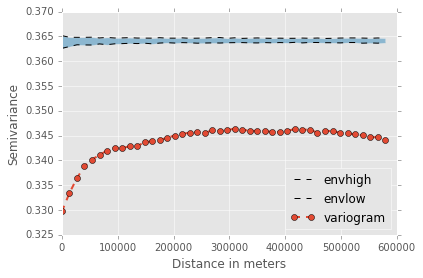

In [35]:

hx = np.linspace(0,600000,100)
vg = tools.Variogram(section,'residuals2',using_distance_threshold=500000)
#plt.figsize=(16,10)
gvg.plot(refresh=False,legend=False)

## already fitted previously
s = 0.345255240992
r = 65857.797111
nugget = 0.332850902482

In [38]:
### Optimizing the empirical values
from scipy.optimize import curve_fit
s = 0.345
r = 100000.0
nugget = 0.33
init_vals = [0.34, 50000, 0.33]   

init_matern = [50000,0.5,0.34]
# for [amp, cen, wid]
bg, covar_gaussian = curve_fit(gaussianVariogram, xdata=vdata.lags.values, ydata=vdata.variogram.values, p0=init_vals)
be, covar_exp = curve_fit(exponentialVariogram, xdata=vdata.lags.values, ydata=vdata.variogram.values, p0=init_vals)
bs, covar_spher = curve_fit(sphericalVariogram, xdata=vdata.lags.values, ydata=vdata.variogram.values, p0=init_vals)
###
bestmatern,covar_matern = curve_fit(MaternVariogram,xdata=vdata.lags.values,ydata=vdata.variogram.values,p0=init_matern)
#gaussianVariogram(hx)
#s =best_vals[0]
#r = best_vals[1]
#nugget = best_vals[2]
#fitted_gaussianVariogram = lambda x : exponentialVariogram(x,sill=s,range_a=r,nugget=nugget)
#gammas = pd.DataFrame(map(fitted_gaussianVariogram,hx))
#import functools
#fitted_gaussian2 = functools.partial(gaussianVariogram,s,r,nugget)

/opt/conda/envs/biospytial/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [148]:
def theoreticalVariogram(model_function,sill,range_a,nugget):
    return lambda x : model_function(x,sill,range_a,nugget)

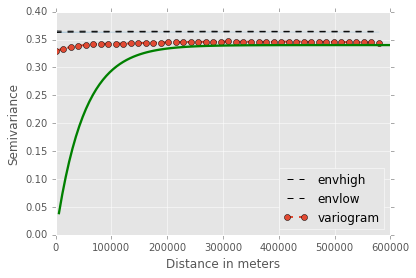

In [40]:
gau_var = gaussianVariogram(hx,bg[0],bg[1],bg[2])
exp_var = exponentialVariogram(hx,be[0],be[1],be[2])
sph_var = sphericalVariogram(hx,bs[0],bs[1],bs[2])
matern_var = MaternVariogram(hx,bestmatern[0],bestmatern[1],bestmatern[2])
## The best is the gaussian
#model_var = theoreticalVariogram(gaussianVariogram,bg[0],bg[1],bg[2])

gvg.plot(refresh=False,legend=False)
plt.plot(hx,matern_var,color='green',lw=2.3)
#plt.plot(hx,exp_var)
#plt.plot(hx,sph_var)


## Model fitting with GLS

In [178]:
import statsmodels.regression.linear_model as lm
Mdist = gvg.distance_coordinates.flatten()
%time vars = np.array(map(model_var,Mdist))
CovMat = vars.reshape(len(section),len(section))
X = section.logSppN.values
Y = section.logBiomass.values

In [ ]:
vars.shape

In [ ]:
plt.imshow(CovMat)

In [ ]:
%time model = lm.GLS(Y,X,sigma=CovMat)

In [ ]:
%time results = model.fit()

## Residuals of $ Biomass ~ SppRich + Z(x,y) + \epsilon $
Using all data
$$\gamma (h) = \frac{1}{\Gamma (\kappa) 2^{\kappa - 1}}\Big[\frac{\sqrt{ 2 \kappa }}{r} h \Big]^\kappa K_{\kappa} \Big( \frac{\sqrt{2\kappa}}{r} h \Big)$$   


$$\gamma(h) = \sigma^2 \Big(1 - \frac{2^{1-\kappa}}{\Gamma(\kappa)}\Big) \Big(\frac{h}{r}\Big)^{\kappa}K_\kappa \Big(\frac{h}{r}\Big)$$


source: http://www.sciencedirect.com/science/article/pii/S0098300408000666#bib5